<a href="https://colab.research.google.com/github/neutro-jina/study_log/blob/main/%EB%AA%A8%EB%91%90%EC%9D%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D/20_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
11501568/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7053  g_loss:0.6912
epoch:1  d_loss:0.4626  g_loss:0.3284
epoch:2  d_loss:0.5721  g_loss:0.1035
epoch:3  d_loss:0.6593  g_loss:0.0859
epoch:4  d_loss:0.5765  g_loss:0.1688
epoch:5  d_loss:0.5083  g_loss:0.4278
epoch:6  d_loss:0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


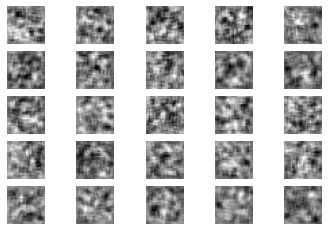

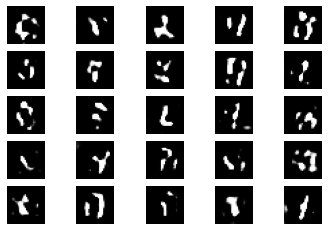

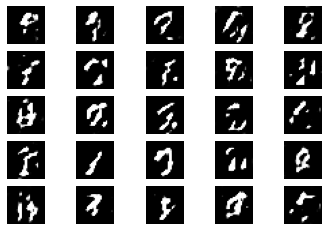

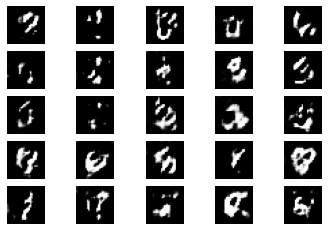

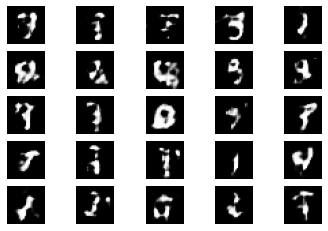

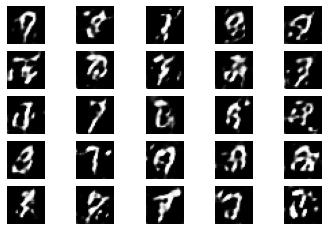

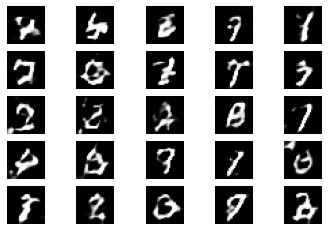

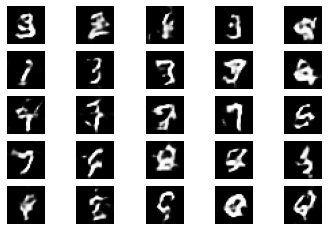

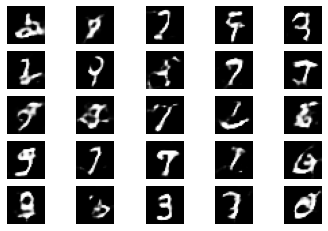

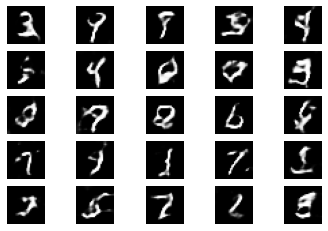

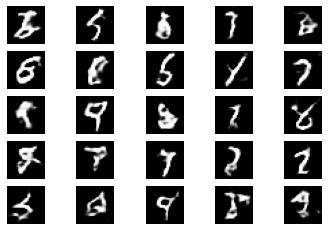

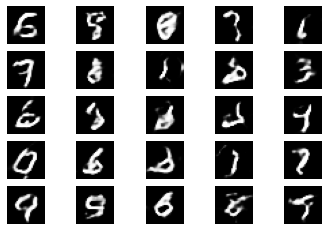

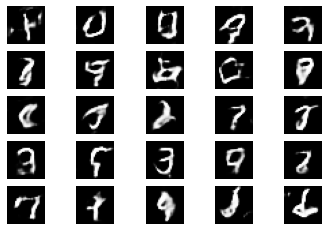

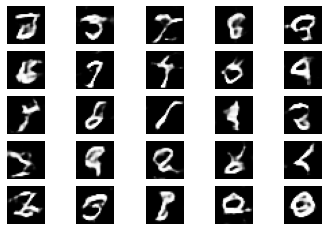

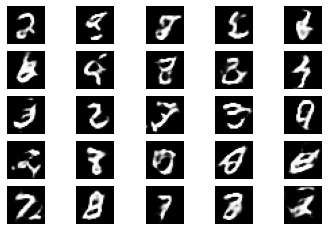

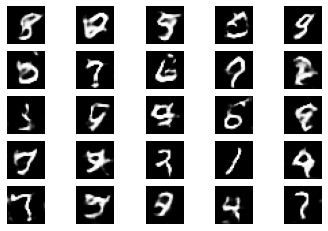

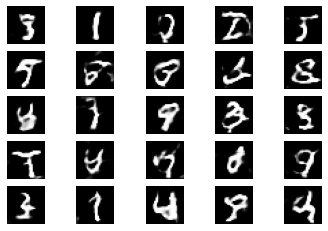

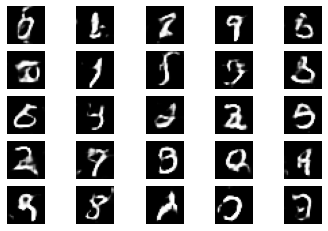

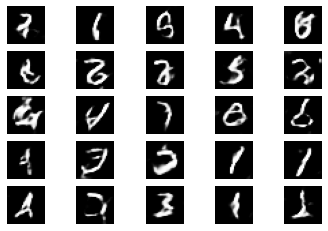

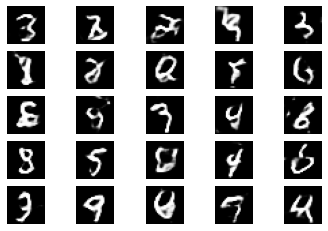

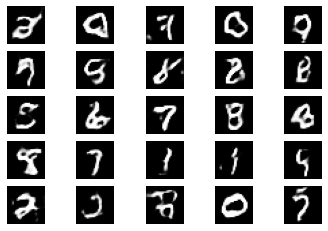

In [1]:
#19장. GAN(Generative Adversarial Netwroks, 생성적 적대 신경망)
# 페이스북의 DCGAN참조
# GAN의 원리는, 한쪽은 가짜를 만들고 한쪽은 진짜와 비교하는 경합의 과정을 이용하는 것


from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

np.random.seed(3)
tf.random.set_seed(3)


#""생성자 모델을 만듭니다.""
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # gan에서는 기존의 relu를 쓰면 불안정해지는 경우가 많아, relu를 변형한 LeakyReLU함수를 사용함.
#128은 임의로 정한 노드의 수, 
#7*7은 이미지의 최초 크기, <= 가로 세로 크기를 2배씩 늘려주는 UpSampling2D()를 사용하였기 때문에. 
#input_dim은 설정한 차원 크기의 랜덤 벡터를 준비해 집어넣으라는 뜻.
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128))) #컨볼루션 레이어가 받아들일 수 있는 형태로 바꾸어주는 코드. conv2d함수의 input_shape부분에 들어갈 형태로 정해줌
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same')) #padding='same'조건으로 커널의 모자라는 부분은 자동으로 0으로 채워줌.
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 마지막 활성화함수는 tanh를 사용한다.


# BatchNormalization(배치정규화): 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것, 다음 층으로 입력될 값을 일정하게 재배치하는 역할을 수행함.




#""판별자 모델을 만듭니다."" 모델 이름을 discriminator로 정의.
# 판별자 부분은 컨볼루션 신경망의 구조를 그대로 가지고 와서 만들면 된다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same")) #strides는 커널 윈도를 몇 칸씩 이동시킬지 정하는 옵션.가로 세로 크기가 줄어들어 새로운 특징 뽑아주는 효과 생김.
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
#false인 이유=> 판별자가 얻은 가중치는 판별자 자신이 학습하는데 쓰이는 게 아니라 생성자로 넘겨 주어 생성자가 업데이트된 이미지를 만들도록 해야 함.



#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,)) #랜덤한 100개의 벡터를 케라스의 input()함수에 집어넣어 생성자에 입력한 ginput을 만드는 과정
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval): # saving_interval: 중간과정을 저장할 때 몇 번마다 한 번씩 저장할지 정함.

  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') #가로 28, 세로28 픽셀이고 흑백이므로 1설정.
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1)) #모두 진짜(1)라는 레이블 값을 가진 열을 batch_size길이만큼 만든다.
  fake = np.zeros((batch_size, 1)) #모두 가짜(0)라는 레이블 값을 가진 열을 batch_size길이만큼 만든다.

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size) #0부터 X_train개수 사이의 숫자를 랜덤하게 선택해 batch_size만큼 반복해서 가져오라는 의미
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)
          #train_on_batch(gen_imgs, fake)는 입력값 gen_imgs와 레이블fake를 받아서 딱 한 번 학습을 실시해 모델을 업데이트한다. 


          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)



          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #d_loss_real, d_loss_fake값을 더해 둘로 나눈 평균이 바로 판별차의 오차이다.
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.
